#### This notebook demonstrates the use of a reweighing pre-processing algorithm for bias mitigation


In [1]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from aif360.algorithms.preprocessing import DisparateImpactRemover

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import os

import pandas as pd

from aif360.datasets import StandardDataset
from sklearn.preprocessing import MinMaxScaler

# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric



d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\torch\_functorch\deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [2]:

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [3]:
def evaluate_model(model, X_test, y_test):
    """Evaluates the model and returns performance metrics

    Args:
        modelTrained model
        X_testTest features
        y_test: Test labels

    Returns:
        Dictionary containing fpr, tnr, npr, fnr, precision, recall, f1
    """
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f'TN {tn}, FP {fp}, FN {fn}, TP {tp}')
    fpr = fp / (fp + tp)  # False Positive Rate
    tnr = tn / (tn + fp)  # True Negative Rate
    tpr = tp / (tp + fn)  # True Positive Rate
    fnr = fn / (fn + tn)  # False Negative Rate
    precision = tp / (tp + fp)  # Precision
    recall = tp / (tp + fn)  # Recall
    f1 = 2 * (precision * recall) / (precision + recall)  # F1 Score

    return {
        "fpr": fpr,
        "tnr": tnr,
        "tpr": tpr,
        "fnr": fnr,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [4]:
class BenefitsDataset(StandardDataset):
    """Benefits Census Income Dataset.

    See :file:`aif360/data/raw/adult/README.md`.
    """

    def __init__(self,df, label_name='checked',
                 favorable_classes=[1],
                 protected_attribute_names=['persoon_geslacht_vrouw', 'persoon_leeftijd_bij_onderzoek'],
                 privileged_classes=[[0], [1]],
                 instance_weights_name=None,
                 categorical_features=[],
                 features_to_keep=[], features_to_drop=[],
                 na_values=['?'], custom_preprocessing=None,
                 metadata=None):


        super(BenefitsDataset, self).__init__(df=df, label_name=label_name,
            favorable_classes=favorable_classes,
            protected_attribute_names=protected_attribute_names,
            privileged_classes=privileged_classes,
            instance_weights_name=instance_weights_name,
            categorical_features=categorical_features,
            features_to_keep=features_to_keep,
            features_to_drop=features_to_drop, na_values=na_values,
            custom_preprocessing=custom_preprocessing, metadata=metadata)


In [5]:

# privileged classes
all_privileged_classes = {"persoon_geslacht_vrouw": [0.0],
                            "persoon_leeftijd_bij_onderzoek": [0.0],
                            'belemmering_ind': [0.0],
                            'belemmering_ind_hist': [0.0],
                            'typering_ind': [0.0],
                             'typering_hist_inburgeringsbehoeftig': [0.0],
                             'persoonlijke_eigenschappen_ind_activering_traject': [0.0],
                             'persoonlijke_eigenschappen_ind_buiten_kantoortijden': [0.0],
                             'persoonlijke_eigenschappen_ind_regulier_arbeidsritme': [0.0],
                        #     'adres_recentst_onderdeel_rdam': [0.0],
                        #     'adres_recentste_buurt_groot_ijsselmonde': [0.0], 
                        #     'adres_recentste_buurt_nieuwe_westen': [0.0], 
                        #     'adres_recentste_buurt_other': [0.0], 
                        #     'adres_recentste_buurt_oude_noorden': [0.0], 
                        #     'adres_recentste_buurt_vreewijk': [0.0], 
                        #     'adres_recentste_plaats_other': [0.0], 
                        #     'adres_recentste_plaats_rotterdam': [0.0], 
                        #     'adres_recentste_wijk_charlois': [0.0], 
                        #     'adres_recentste_wijk_delfshaven': [0.0], 
                        #     'adres_recentste_wijk_feijenoord': [0.0], 
                        #     'adres_recentste_wijk_ijsselmonde': [0.0], 
                        #     'adres_recentste_wijk_kralingen_c': [0.0], 
                        #     'adres_recentste_wijk_noord': [0.0], 
                        #     'adres_recentste_wijk_other': [0.0], 
                        #     'adres_recentste_wijk_prins_alexa': [0.0], 
                        #     'adres_recentste_wijk_stadscentru': [0.0],
                            # 'relatie_kind_huidige_aantal': [0.0],
                            # 'relatie_kind_leeftijd_verschil_ouder_eerste_kind': [0.0],
                            #  'relatie_partner_aantal_partner___partner__gehuwd_': [1.0],
                            #  'relatie_partner_aantal_partner___partner__ongehuwd_': [1.0],
                            #  'relatie_partner_huidige_partner___partner__gehuwd_': [1.0],
                            #  'relatie_overig_kostendeler': [1.0],
                            #  'relatie_kind_heeft_kinderen': [0.0],     

                             
                    }

privileged_groups = [
                    {'persoon_geslacht_vrouw': 0}, 
                    {'persoon_leeftijd_bij_onderzoek': 0},
                    {'belemmering_ind': 0},
                    {'belemmering_ind_hist': 0},
                    {'typering_ind': 0},
                    {'typering_hist_inburgeringsbehoeftig': 0.0},
                    {'persoonlijke_eigenschappen_ind_activering_traject': 0.0},
                    {'persoonlijke_eigenschappen_ind_buiten_kantoortijden': 0.0},
                    {'persoonlijke_eigenschappen_ind_regulier_arbeidsritme': 0.0},
                #     {'adres_recentst_onderdeel_rdam': 0.},
                #     {'adres_recentste_buurt_groot_ijsselmonde': 0.}, 
                #     {'adres_recentste_buurt_nieuwe_westen': 0.}, 
                #     {'adres_recentste_buurt_other': 0.}, 
                #     {'adres_recentste_buurt_oude_noorden': 0.}, 
                #     {'adres_recentste_buurt_vreewijk': 0.},
                #     {'adres_recentste_plaats_other':0.}, 
                #     {'adres_recentste_plaats_rotterdam': 0.} , 
                #     {'adres_recentste_wijk_charlois':0.}, 
                #     {'adres_recentste_wijk_delfshaven':0.}, 
                #     {'adres_recentste_wijk_feijenoord': 0.}, 
                #     {'adres_recentste_wijk_ijsselmonde': 0.}, 
                #     {'adres_recentste_wijk_kralingen_c': 0.}, 
                #     {'adres_recentste_wijk_noord': 0.}, 
                #     {'adres_recentste_wijk_other': 0.}, 
                #     {'adres_recentste_wijk_prins_alexa': 0.}, 
                #     {'adres_recentste_wijk_stadscentru': 0.},
                    # {'relatie_kind_huidige_aantal': [0.0]},
                    # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': [0.0]},
                    # {'relatie_partner_aantal_partner___partner__gehuwd_': 1.0},
                    # {'relatie_partner_aantal_partner___partner__ongehuwd_': 1.0},
                    # {'relatie_partner_huidige_partner___partner__gehuwd_': 1.0},
                    # {'relatie_overig_kostendeler': 1.0},
                    ]

unprivileged_groups = [{'persoon_geslacht_vrouw': 1}, 
                        {'persoon_leeftijd_bij_onderzoek': 1},
                        {'belemmering_ind': 1},
                        {'belemmering_ind_hist': 1},
                        {'typering_ind': 1},
                        {'typering_hist_inburgeringsbehoeftig': 1.0},
                        {'persoonlijke_eigenschappen_ind_activering_traject': 1.0},
                        {'persoonlijke_eigenschappen_ind_buiten_kantoortijden': 1.0},
                        {'persoonlijke_eigenschappen_ind_regulier_arbeidsritme': 1.0},
                        # {'adres_recentst_onderdeel_rdam': 1.},
                        # {'adres_recentste_buurt_groot_ijsselmonde': 1.}, 
                        # {'adres_recentste_buurt_nieuwe_westen': 1.}, 
                        # {'adres_recentste_buurt_other': 1.}, 
                        # {'adres_recentste_buurt_oude_noorden': 1.}, 
                        # {'adres_recentste_buurt_vreewijk': 1.},
                        # {'adres_recentste_plaats_other': 1.}, 
                        # {'adres_recentste_plaats_rotterdam': 1.} , 
                        # {'adres_recentste_wijk_charlois': 1.}, 
                        # {'adres_recentste_wijk_delfshaven': 1.}, 
                        # {'adres_recentste_wijk_feijenoord': 1.}, 
                        # {'adres_recentste_wijk_ijsselmonde': 1.}, 
                        # {'adres_recentste_wijk_kralingen_c': 1.}, 
                        # {'adres_recentste_wijk_noord': 1.}, 
                        # {'adres_recentste_wijk_other': 1.}, 
                        # {'adres_recentste_wijk_prins_alexa': 1.}, 
                        # {'adres_recentste_wijk_stadscentru': 1.},
                        # # {'relatie_kind_huidige_aantal': 1},
                        # {'relatie_kind_huidige_aantal': 2},
                        # {'relatie_kind_huidige_aantal': 3},
                        # {'relatie_kind_huidige_aantal': 4},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 1},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 2},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 3},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 4},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 5},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 6},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 7},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 8},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 9},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 10},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 11},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 12},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 13},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 14},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 15},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 16},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 17},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 18},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 19},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 20},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 21},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 22},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 23},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 24},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 25},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 26},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 27},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 28},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 29},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 30},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 31},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 32},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 33},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 34},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 35},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 36},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 37},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 38},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 39},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 40},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 41},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 42},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 43},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 44},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 45},
                        # {'relatie_kind_leeftijd_verschil_ouder_eerste_kind': 46},
                        # {'relatie_partner_aantal_partner___partner__gehuwd_': 0.0},
                        # {'relatie_partner_aantal_partner___partner__ongehuwd_': 1.},
                        # {'relatie_partner_huidige_partner___partner__gehuwd_': 0.0},
                        # {'relatie_overig_kostendeler': 0.0},
                        ]
        


In [6]:
def preprocess(data, target_label='checked'):
    
    # Define your features and target
    X = data.drop(target_label, axis=1)
    y = data[target_label]

    # # Identify numeric and categorical columns
    # numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

    # # Impute and scale numeric features
    # scaler = StandardScaler()
    # for col in numeric_features:
    #     imputer = SimpleImputer(strategy='median')
    #     X[col] = imputer.fit_transform(X[[col]])
    #     X[col] = imputer.transform(X[[col]])
        
    #     X[col] = scaler.fit_transform(X[[col]])
    #     X[col] = scaler.transform(X[[col]])

    return X, y


In [7]:
def load_preproc_data_benefits(all_privileged_classes, is_train=False):
    """
    Load and pre-process german credit dataset.
    Args:
        protected_attributes(list or None): If None use all possible protected
            attributes, else subset the protected attributes to the list.

    Returns:
        GermanDataset: An instance of GermanDataset with required pre-processing.

    """
    def custom_preprocessing(df):
        """ Custom pre-processing for German Credit Data
        """

        df['persoon_leeftijd_bij_onderzoek'] = (df['persoon_leeftijd_bij_onderzoek'] <= 27).astype(float)

        return df
    
    X_train =  X_test =  y_train= y_test=None
    

    if is_train == True:
        ds_train = pd.read_csv('./../data/train.csv')
        ds_test = pd.read_csv('./../data/test.csv')
        df_train = ds_train.copy()
        df_test = ds_test.copy()
    
        X_train, y_train = preprocess(ds_train)
        X_test, y_test = preprocess(ds_test)

    else:
        data = pd.read_csv('./../data/synth_data_for_training.csv')
        data = data.astype(np.float32)
  
        features = data[:-1]
        target = data[-1]
        X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2)
        df_train = pd.concat([X_train, y_train], axis=1)
    

    # Feature partitions
    XD_features = ["persoon_geslacht_vrouw",
                    "persoon_leeftijd_bij_onderzoek",
                    'belemmering_ind',
                    'belemmering_ind_hist',
                    'typering_ind',
                    'typering_hist_inburgeringsbehoeftig',
                    'persoonlijke_eigenschappen_ind_activering_traject',
                    'persoonlijke_eigenschappen_ind_buiten_kantoortijden',
                    'persoonlijke_eigenschappen_ind_regulier_arbeidsritme',
                    # 'adres_recentst_onderdeel_rdam',
                    # 'adres_recentste_buurt_groot_ijsselmonde',
                    # 'adres_recentste_buurt_nieuwe_westen', 
                    # 'adres_recentste_buurt_other', 
                    # 'adres_recentste_buurt_oude_noorden', 
                    # 'adres_recentste_buurt_vreewijk', 
                    # 'adres_recentste_plaats_other', 
                    # 'adres_recentste_plaats_rotterdam', 
                    # 'adres_recentste_wijk_charlois', 
                    # 'adres_recentste_wijk_delfshaven', 
                    # 'adres_recentste_wijk_feijenoord', 
                    # 'adres_recentste_wijk_ijsselmonde', 
                    # 'adres_recentste_wijk_kralingen_c', 
                    # 'adres_recentste_wijk_noord', 
                    # 'adres_recentste_wijk_other', 
                    # 'adres_recentste_wijk_prins_alexa', 
                    # 'adres_recentste_wijk_stadscentru',
                    # 'relatie_kind_huidige_aantal',
                    # 'relatie_kind_leeftijd_verschil_ouder_eerste_kind',
                    # 'relatie_partner_huidige_partner___partner__gehuwd_',
                    # 'relatie_partner_aantal_partner___partner__gehuwd_',
                    # 'relatie_partner_aantal_partner___partner__ongehuwd_',
                    # 'relatie_overig_kostendeler',
                    ]
    D_features = XD_features
    Y_features = ['checked']
    X_features = list(set(XD_features)-set(D_features))

    
    ds_train = BenefitsDataset(df=df_train,
        label_name=Y_features[0],
        favorable_classes=[1],
        protected_attribute_names=D_features,
        privileged_classes=[all_privileged_classes[x] for x in D_features],
        instance_weights_name=None,
        features_to_keep=X_features+Y_features+D_features,
        custom_preprocessing=custom_preprocessing)
    ds_test = BenefitsDataset(df=df_train,
        label_name=Y_features[0],
        favorable_classes=[1],
        protected_attribute_names=D_features,
        privileged_classes=[all_privileged_classes[x] for x in D_features],
        instance_weights_name=None,
        features_to_keep=X_features+Y_features+D_features,
        custom_preprocessing=custom_preprocessing)
        
    return ds_train, ds_test, X_train, X_test, y_train, y_test



#### Load dataset and set options

In [8]:
## import dataset

def run(all_privileged_classes, unprivileged_groups, privileged_groups, save_model_weights="", num_iterations=1):
    
    # Initialize lists to store metrics
    fprs = []
    tnrs = []
    tprs = []
    fnrs = []
    precisions = []
    recalls = []
    f1s = []

    
    dataset_train, dataset_test, X_train, X_test, y_train, y_test = load_preproc_data_benefits(all_privileged_classes=all_privileged_classes,
                                                                                    is_train=True)    
    scaler = MinMaxScaler(copy=False)

    dataset_train.features = scaler.fit_transform(dataset_train.features)
    dataset_test.features = scaler.fit_transform(dataset_test.features)

    for level in tqdm(np.linspace(0., 1., 11)):
        # Train-test split

        di = DisparateImpactRemover(repair_level=level)
        train_repd = di.fit_transform(dataset_train)
        test_repd = di.fit_transform(dataset_train)
        

        model = GradientBoostingClassifier(n_estimators=300, min_samples_split=800, min_samples_leaf=125, max_depth=5, learning_rate=0.155)
        model.fit(X_train, y_train, sample_weight=weights['instance_weights'])

        # # Evaluate model
        metrics = evaluate_model(model, X_test, y_test)
        fprs.append(metrics["fpr"])
        tnrs.append(metrics["tnr"])
        tprs.append(metrics["tpr"])
        fnrs.append(metrics["fnr"])
        precisions.append(metrics["precision"])
        recalls.append(metrics["recall"])
        f1s.append(metrics["f1"])
        
    print("Average Performance:")
    print(f"FPR: {sum(fprs) / len(fprs):.4f}")
    print(f"TNR: {sum(tnrs) / len(tnrs):.4f}")
    print(f"TPR: {sum(tprs) / len(tprs):.4f}")
    print(f"FNR: {sum(fnrs) / len(fnrs):.4f}")
    print(f"Precision: {sum(precisions) / len(precisions):.4f}")
    print(f"Recall: {sum(recalls) / len(recalls):.4f}")
    print(f"F1: {sum(f1s) / len(f1s):.4f}")
    

In [9]:
run(num_iterations=1, 
    all_privileged_classes=all_privileged_classes, 
    privileged_groups=privileged_groups, 
    unprivileged_groups=unprivileged_groups,
    save_model_weights="./../data/instance_weights.csv")

KeyError: 'distortion_fun'

In [ ]:
from sklearn.metrics import recall_score

def custom_scoring(y_true, y_pred, fp_threshold=0.005):
  """
  Custom scoring function that combines recall with false positive control.

  Args:
      y_true: Ground truth labels.
      y_pred: Predicted labels.
      fp_threshold: Maximum tolerable false positive rate.

  Returns:
      A score combining recall and false positive control.
  """
  recall = recall_score(y_true, y_pred)
  false_positives = (y_pred == 1) & (y_true == 0)
  false_positive_rate = false_positives.sum() / len(y_true)
  penalty = 0  # Adjust penalty weight for false positives
  if false_positive_rate > fp_threshold:
    penalty = (false_positive_rate - fp_threshold) ** 2  # Increase penalty quadratically for exceeding threshold
  return recall - penalty


### Train classifier on original data

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define the parameter grid
param_grid = {
    'learning_rate':  [0.1525, 0.155, 0.1575],
    'n_estimators': [250, 300, 350],
    'max_depth': [5],
    'min_samples_split': [250, 500, 750],
    'min_samples_leaf': [25, 75, 125],
    'loss': ['log_loss', 'exponential']
}

# Create the GradientBoostingClassifier model
model = GradientBoostingClassifier()

# Define the GridSearchCV object
grid_search = RandomizedSearchCV(model, param_grid, scoring=custom_scoring, cv=5, n_jobs=4)



model = GradientBoostingClassifier()

ds_train = pd.read_csv('./../data/train.csv')
ds_test = pd.read_csv('./../data/test.csv')
instance_weights = pd.read_csv('./../data/instance_weights.csv')['instance_weights']
print(instance_weights.shape)

X_train, y_train = preprocess(ds_train)
X_test, y_test = preprocess(ds_test)
    
# Fit the grid search to the data
grid_search.fit(X_train, y_train, sample_weight=instance_weights.to_numpy())

    
# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

y_pred_rew = grid_search.predict(X_test)

results = classification_report(y_test, y_pred_rew)
(tn, fp, fn, tp)  = confusion_matrix(y_test, y_pred_rew).ravel()
print(f"tn: {tn} fp: {fp} fn: {fn} tp: {tp} ")
print(results)


(10116,)


In [ ]:
y_pred_rew = grid_search.predict(X_test)

results = classification_report(y_test, y_pred_rew)
(tn, fp, fn, tp)  = confusion_matrix(y_test, y_pred_rew).ravel()
print(f"tn: {tn} fp: {fp} fn: {fn} tp: {tp} ")
print(results)

tn: 2243 fp: 17 fn: 114 tp: 155 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2260
           1       0.90      0.58      0.70       269

    accuracy                           0.95      2529
   macro avg       0.93      0.78      0.84      2529
weighted avg       0.95      0.95      0.94      2529



In [ ]:
print(results)
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2402
           1       0.39      0.83      0.54       127

    accuracy                           0.93      2529
   macro avg       0.69      0.88      0.75      2529
weighted avg       0.96      0.93      0.94      2529

[[2239  163]
 [  21  106]]


#### Obtain scores for original validation and test sets

In [ ]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [ ]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups_age,
                                             privileged_groups=privileged_groups_age)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.5339
Optimal classification threshold (no reweighing) = 0.1090


### Predictions from the original test set at the optimal classification threshold

In [ ]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                     unprivileged_groups_age, privileged_groups_age,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.1090


  0%|          | 0/100 [00:00<?, ?it/s]d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
 42%|████▏     | 42/100 [00:00<00:00, 411.78it/s]

Balanced accuracy = 0.5157
Statistical parity difference = 1.0000
Disparate impact = inf
Average odds difference = 1.0000
Equal opportunity difference = 1.0000
Theil index = 0.0932


100%|██████████| 100/100 [00:00<00:00, 423.73it/s]


#### Display results for all thresholds

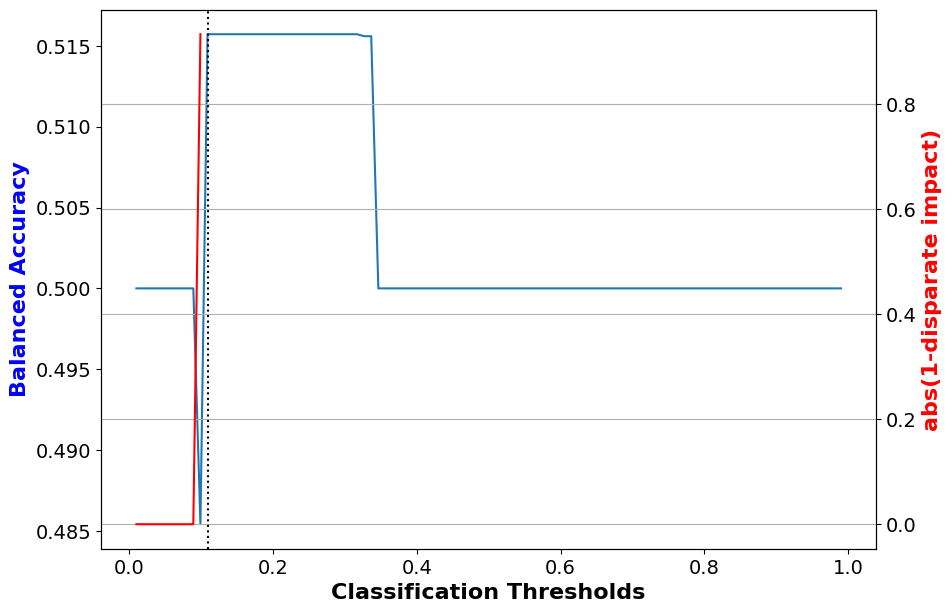

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

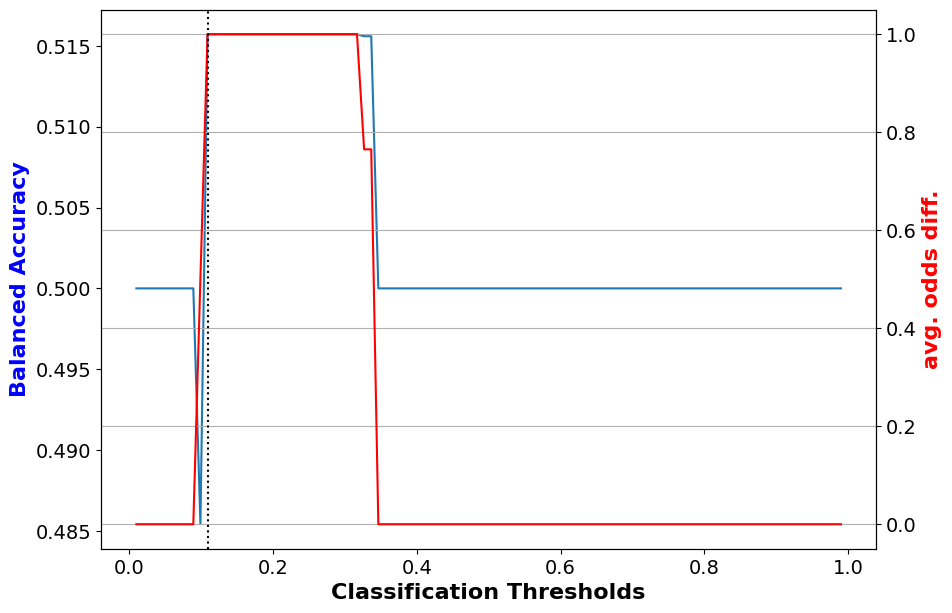

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

### Train classifier on transformed data

In [ ]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

#### Obtain scores for transformed test set

In [ ]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Predictions from the transformed test set at the optimal classification threshold

In [ ]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.1090


  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: 'age' is not in list

#### Display results for all thresholds

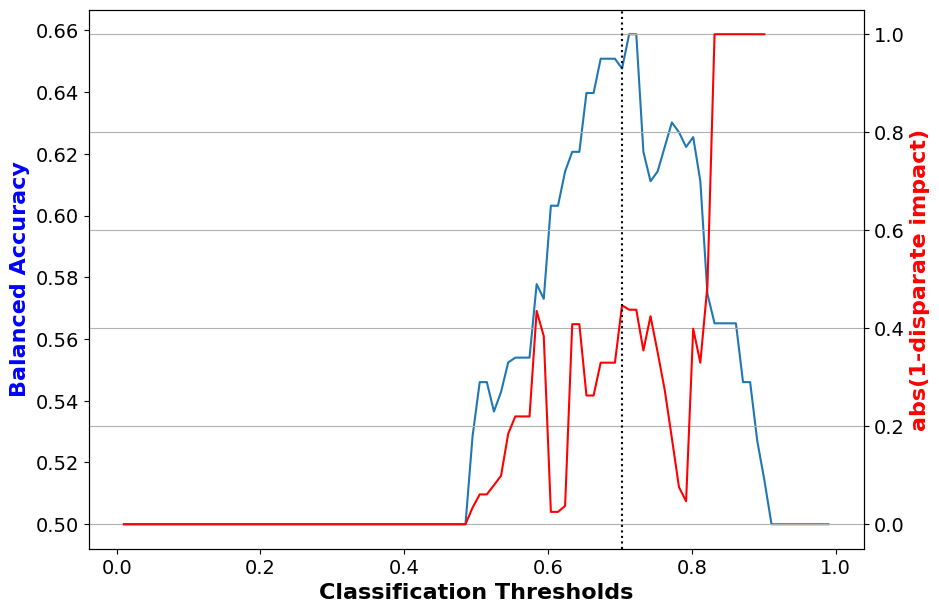

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

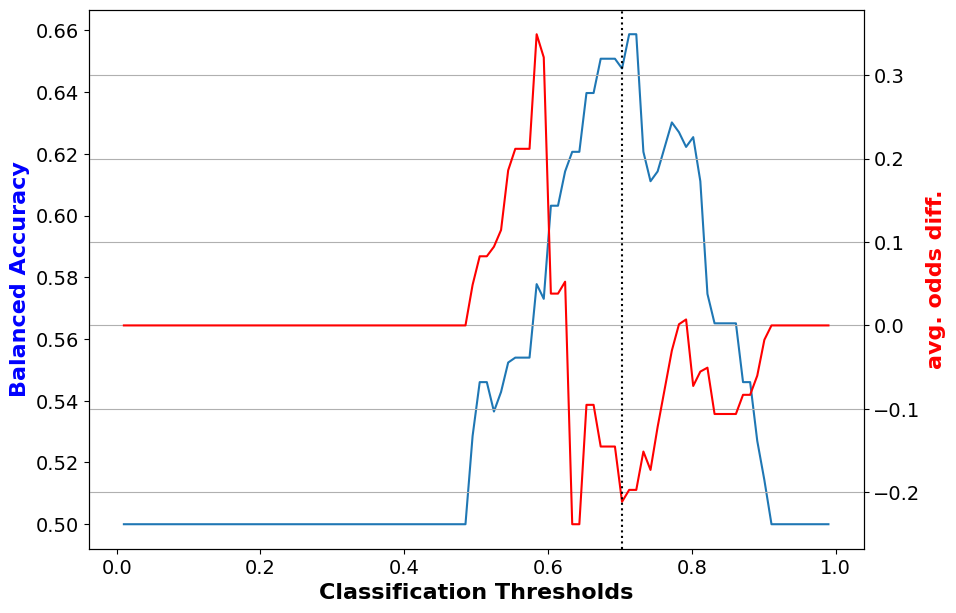

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

# Summary of Results
We show the optimal classification thresholds, and the fairness and accuracy metrics.

### Classification Thresholds

| Dataset |Classification threshold|
|-|-|
|Adult||0.2674|
|German|0.6732|
|Compas|0.5148|

### Fairness Metric: Disparate impact, Accuracy Metric: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|Race/Age (Acc-Bef)|Race/Age (Acc-Aft)|Race/Age (Fair-Bef)|Race/Age (Fair-Aft)|
|-|-|-|-|-|-|-|-|-|
|Adult (Test)|0.7417|0.7128|0.2774|0.7625|0.7417|0.7443|0.4423|0.7430|
|German (Test)|0.6524|0.6460|0.9948|1.0852|0.6524|0.6460|0.3824|0.5735|
|Compas (Test)|0.6774|0.6562|0.6631|0.8342|0.6774|0.6342|0.6600|1.1062|



### Fairness Metric: Average odds difference, Accuracy Metric: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|Race/Age (Acc-Bef)|Race/Age (Acc-Aft)|Race/Age (Fair-Bef)|Race/Age (Fair-Aft)|
|-|-|-|-|-|-|-|-|-|
|Adult (Test)|0.7417|0.7128|-0.3281|-0.0266|0.7417|0.7443|-0.1991|-0.0395|
|German (Test)|0.6524|0.6460|0.0071|0.0550|0.6524|0.6460|-0.3278|-0.1944|
|Compas (Test)|0.6774|0.6562|-0.2439|-0.0946|0.6774|0.6342|-0.1927|0.1042|